One particularly interesting channel in `block2.res1.resadd_out` is _channel 55_. In this notebook, we will: 
1. Visualize channel 55 and demonstrate **that it positively activates on cheese and weakly negatively activates elsewhere**, 
2. Demonstrate how the agent can sometimes be retargeted using a simple synthetic activation patch, and
3. Show that this channel can weakly increase cheese-seeking (multiply by >1), decrease cheese-seeking (zero- or mean-ablate), strongly promote cheese-avoidance (multiply by < -1), and promote no-ops (multiply by << -1). 
4. Demonstrate that in `block2.res1.resadd_out` `cheese_channels=[7,8,42,44,55,77,82,88,99,113]` appear to encode cheese position in a similar manner. With the exception of channels `7, 44, 99`, the "cheese channels" mimic channel 55 in that they also individually ret arget the agent's behavior

This notebook will be used for map exploration and saliency mapping purposes. Given that we know the agent was trained with a high probability of misgeneralization, we can use the saliency maps to showcase that via various types of maps.

# Map Exploration
Using some of the functions in the channel_55 notebook, we can customize the maps to our liking.

In [1]:
try:
    import procgen_tools
except ImportError or ModuleNotFoundError:
    get_ipython().run_line_magic(magic_name='pip', line='install -U git+https://github.com/ulissemini/procgen-tools')

from procgen_tools.utils import setup

#setup() # create directory structure and download data 

from procgen_tools.imports import *
from procgen_tools import visualization, patch_utils, maze
import os


In [133]:
cheese_channels = [77, 113, 44, 88, 55, 42, 7, 8, 82, 99] 
effective_channels = [77, 113, 88, 55, 8, 82, 89]

# From procgen_tools/models.py, line 186
MAZE_ACTION_INDICES = {
    'LEFT': [0, 1, 2],
    'DOWN': [3],
    'UP': [5],
    'RIGHT': [6, 7, 8],
    'NOOP': [4,9,10,11,12,13,14],
}

# Reverse the dictionary
reversed_maze_action_indices = {}
for action, indices in MAZE_ACTION_INDICES.items():
    for index in indices:
        reversed_maze_action_indices[index] = action

SAVE_DIR = 'experiments'
AX_SIZE = 6

Try clicking on the left-ward level editor below. Move the cheese around the maze by clicking on the yellow tile, and then clicking on the tile you want to contain the cheese. Watch the positive blue activations equivariantly translate along with the cheese!

In [67]:
# Show a maze editor side-by-side with the interactive plotter
SEED = 12
venv = maze.create_venv(num=1, start_level=SEED, num_levels=1) # This has to be a single maze, otherwise the vfield wont work

default_settings = {'channel_slider': 55, 'label_widget': 'block2.res1.resadd_out'}
custom_maze_plotter = visualization.ActivationsPlotter(labels, lambda activations, fig: visualization.plot_activations(activations[0], fig=fig), patch_utils.values_from_venv, hook, defaults=default_settings, venv=venv)

widget_box = visualization.custom_vfield(policy, venv=venv, callback=custom_maze_plotter.update_plotter) 
display(widget_box)
    
custom_maze_plotter.display() 

Box(children=(HBox(children=(GridspecLayout(children=(Button(layout=Layout(grid_area='widget001', height='0px'…

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': '9bd7f3eb-10ef-4dc9-a4b7-f0b69e06db4c',
              'z': array([[ 0.01991452, -0.13490239, -0.19665515, ..., -0.17179093, -0.12796144,
                            0.01015706],
                          [ 0.02732853, -0.19278221, -0.12898391, ..., -0.16834049, -0.11545651,
                           -0.02889723],
                          [-0.21087873, -0.26189512, -0.23981006, ..., -0.16618828, -0.09322748,
                           -0.09547076],
                  

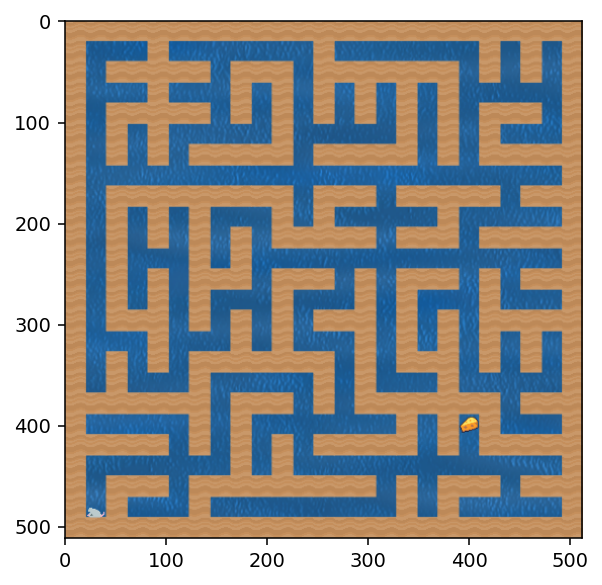

In [32]:
# Nice, so it makes changes directly to the virtual environment without having to go through any hoops. That is really nice. 
render = venv.render(mode='rgb_array')
plt.imshow(render)
plt.show()

# Saliency Mapping Code

In [179]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    '''
    This code is modelled from this repo: 
    https://github.com/sunnynevarekar/pytorch-saliency-maps/tree/master

    A few changes have been made to have the function cooperate with our task at hand.
    '''
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    img.requires_grad = True
    #forward pass to calculate predictions
    preds = model(img)
    score_ind = t.argmax(preds[0].logits)
    logits = preds[0].logits
    score = logits[0, score_ind]
    
    # Get probability of move
    probability = preds[0]
    probability = probability.probs[0, score_ind.numpy()]

    print("probabiltiy distribution: ", preds[0].probs.detach().numpy())

    print("The predicted correct move in this scenario is: ", score_ind.numpy(), " with probability ", probability ,"%")
    
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = t.max(t.abs(img.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    return slc.numpy()

In [167]:
def saliency_for_move(img, model):
    '''
    This code is modelled from this repo: 
    https://github.com/sunnynevarekar/pytorch-saliency-maps/tree/master

    A few changes have been made to have the function cooperate with our task at hand.
    '''
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    img.requires_grad = True
    #forward pass to calculate predictions
    preds = model(img)
    score_ind = t.argmax(preds[0].logits)
    logits = preds[0].logits

    # The thing is, we have a maximum action for some index, but we likely want a saliency mapping for the class of actions equalling (left) or whatever.
    # Because there are so many unnessessary actions, we will not get this with our saliency code.
    
    # Find the action corresponding to the given index
    action = reversed_maze_action_indices[int(score_ind.numpy().item())]
    
    # Get the list of all indices for that action
    related_indices = MAZE_ACTION_INDICES[action]

    # Okay, now we have a list of the moves, lets do some conditional probability work
    probability_map = preds[0].probs.detach().numpy()
    probability = 0.0

    saliency_maps = []
    
    for i in related_indices:
        # Get probability of move
        probability += probability_map[0, i]
        score = logits[0, i]
    
        
        #backward pass to get gradients of score predicted class w.r.t. input image
        score.backward(retain_graph=True)
        #get max along channel axis
        slc, _ = t.max(t.abs(img.grad[0]), dim=0)
        #normalize to [0..1]
        slc = (slc - slc.min())/(slc.max()-slc.min())
        slc = slc.detach().numpy()
        
        saliency_maps.append(slc)

    # now that we have all of the maps as well as total probability, we can get the map summary
    saliency_map = np.zeros(shape=saliency_maps[0].shape)
    j = 0
    for i in related_indices:
        cond_prob = probability_map[0, i]/probability
        c_sal_map = saliency_maps[j]
        saliency_map += cond_prob*c_sal_map
        j += 1
    
    # print out the move

    print("The predicted correct move in this scenario is: ", action, " with probability ", probability ,"%")

    return saliency_map

In [79]:
# turn the maps into tensors
def get_grids():
    new_state = maze.copy_venv(venv, 0)
    return t.tensor(
            new_state.reset(), dtype=t.float32
    )
    

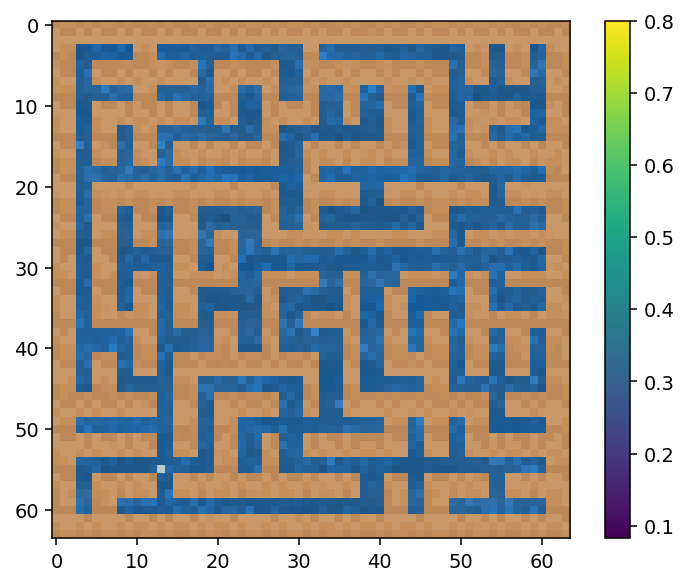

In [80]:
batched_obs = get_grids()
plt.imshow(t.swapaxes(batched_obs[:1].squeeze(axis=0), 1, 2).numpy().T)
plt.colorbar()
plt.show()

The predicted correct move in this scenario is:  5


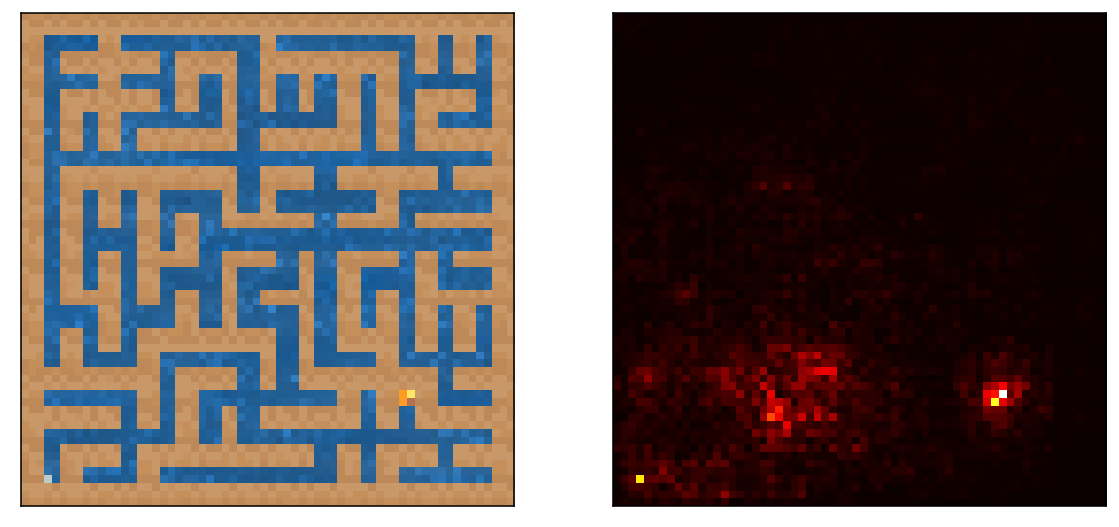

In [46]:

sal_map = saliency(batched_obs[:1], policy)

#plot image and its saleincy map
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(t.swapaxes(batched_obs[:1].squeeze(axis=0), 1, 2).numpy().T)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(sal_map, cmap=plt.cm.hot)
plt.xticks([])
plt.yticks([])
plt.show()

# Experimentation
Definitely a few things we can do with this given the results above as well as the results we saw from the project report.

## Goal Misgeneralization 
I would like to see a few things here:
1. Can we isolate a goal of going to the top right corner without the cheese being present at all (does it by default think that the top right is the best path?)
2. Can we have the mouse go towards the top right corner even if the cheese is the opposite direction?

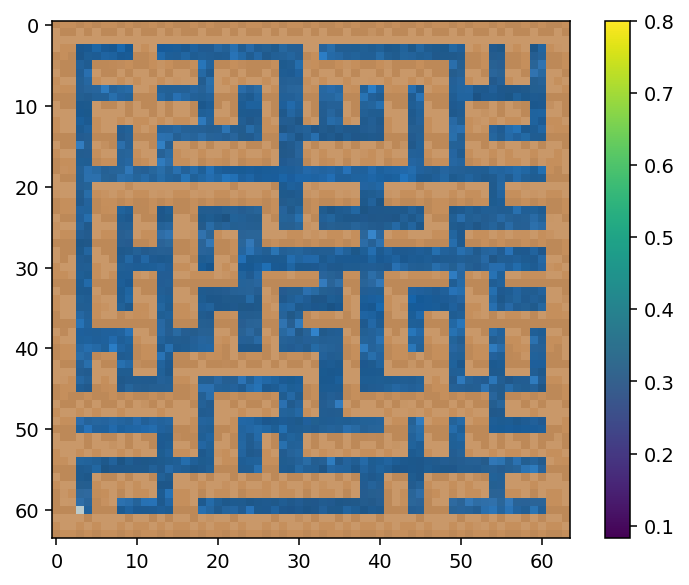

In [52]:
# Since we have a plotter already present, we can modify that plotter and have seperated instances of pytorch tensors to represent
# which one we're working with at any given moment.

# This one will be working with distinctly no cheese
no_cheese = get_grids()
plt.imshow(t.swapaxes(no_cheese[:1].squeeze(axis=0), 1, 2).numpy().T)
plt.colorbar()
plt.show()

The predicted correct move in this scenario is:  5


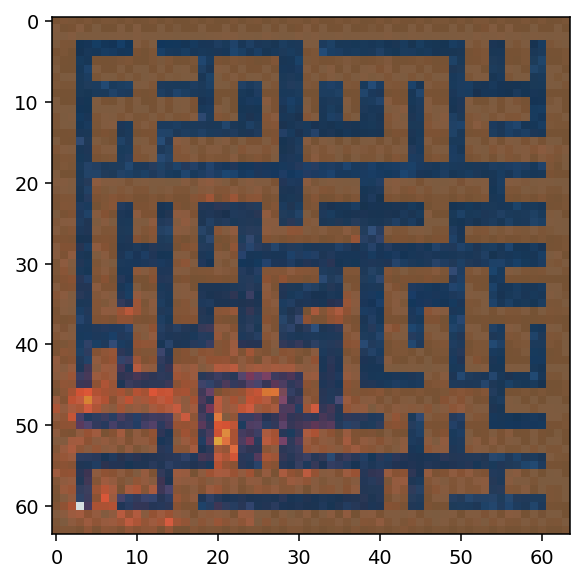

In [64]:
sal_map = saliency(no_cheese[:1], policy)

#plot image and its saleincy map overlapping
plt.imshow(no_cheese[:1].squeeze(axis=0).numpy().transpose(1,2,0))
plt.imshow(sal_map, cmap='hot', alpha=0.4)
plt.show()

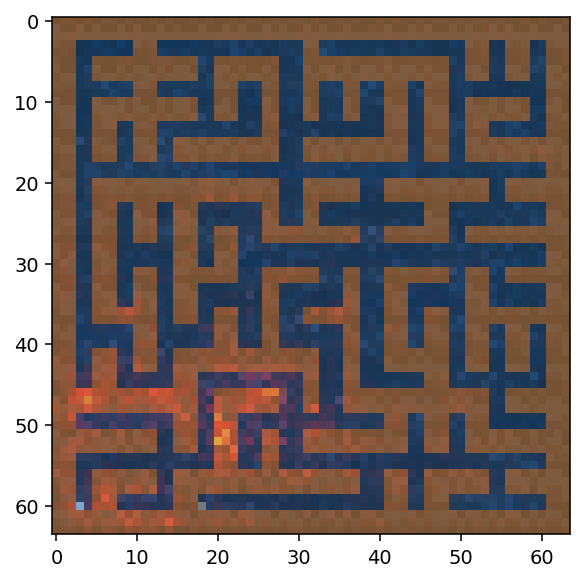

In [66]:
plt.imshow(no_cheese[4:5].squeeze(axis=0).numpy().transpose(1,2,0))
plt.imshow(sal_map, cmap='hot', alpha=0.4)
plt.show()

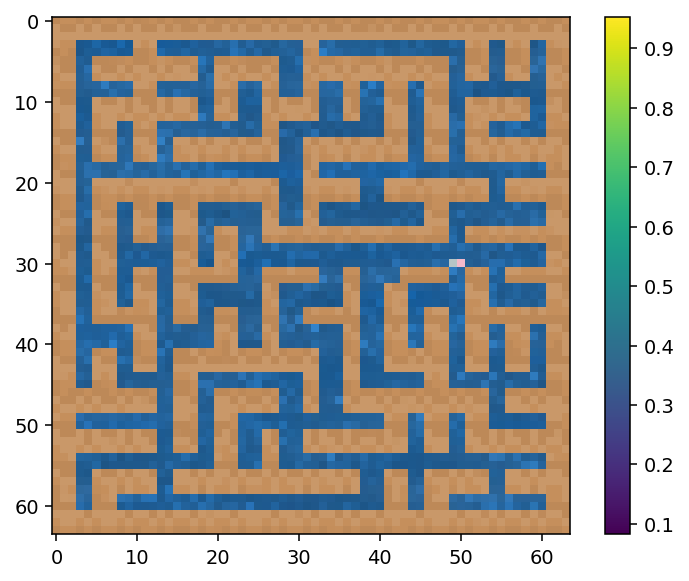

In [81]:
# It may just be recognizing that it only has one real valid move, but what if we have all the moves be valid?

middle_map = get_grids()
plt.imshow(t.swapaxes(middle_map[:1].squeeze(axis=0), 1, 2).numpy().T)
plt.colorbar()
plt.show()

torch.Size([1, 15])
The predicted correct move in this scenario is:  5  with probability  tensor(0.6966, grad_fn=<SelectBackward0>) %


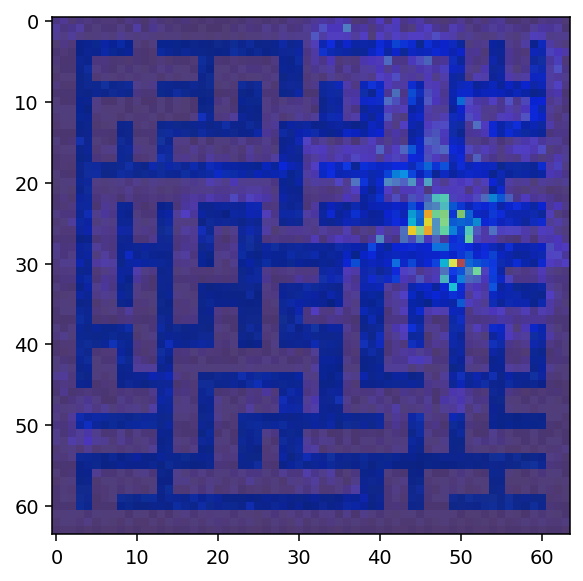

In [127]:
sal_map = saliency(middle_map[:1], policy)

plt.imshow(middle_map[:1].squeeze(axis=0).numpy().transpose(1,2,0))
plt.imshow(sal_map, cmap='jet', alpha=0.6)
plt.show()

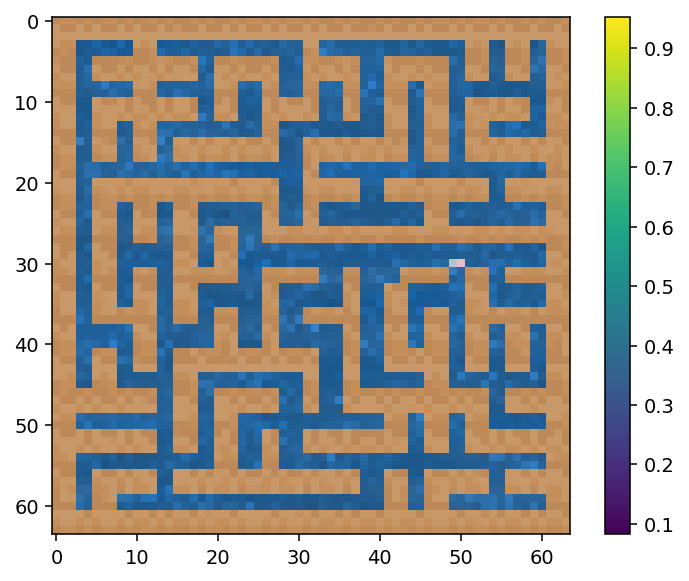

The predicted correct move in this scenario is:  LEFT  with probability  0.47799495607614517 %


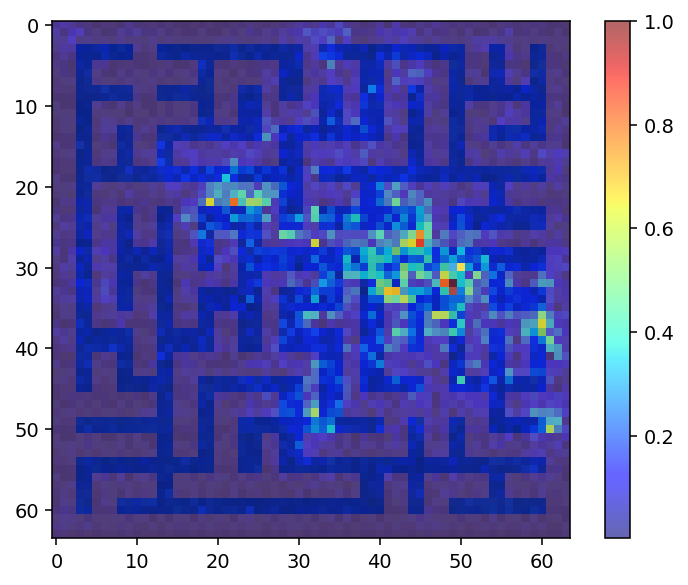

In [169]:
# It still thinks going up is the best move but not because of the top right hand corner. If we seal that off, what will it think?

middle_map = get_grids()
plt.imshow(t.swapaxes(middle_map[:1].squeeze(axis=0), 1, 2).numpy().T)
plt.colorbar()
plt.show()

sal_map = saliency_for_move(middle_map[:1], policy)

plt.imshow(middle_map[:1].squeeze(axis=0).numpy().transpose(1,2,0))
plt.imshow(sal_map, cmap='jet', alpha=0.6)
plt.colorbar()
plt.show()

So, it has a ~50% chance of choosing left over the other types of actions, which means it has a higher probability of taking the action leading to the top left. If we have a easier path to get to the top right, what happens then?

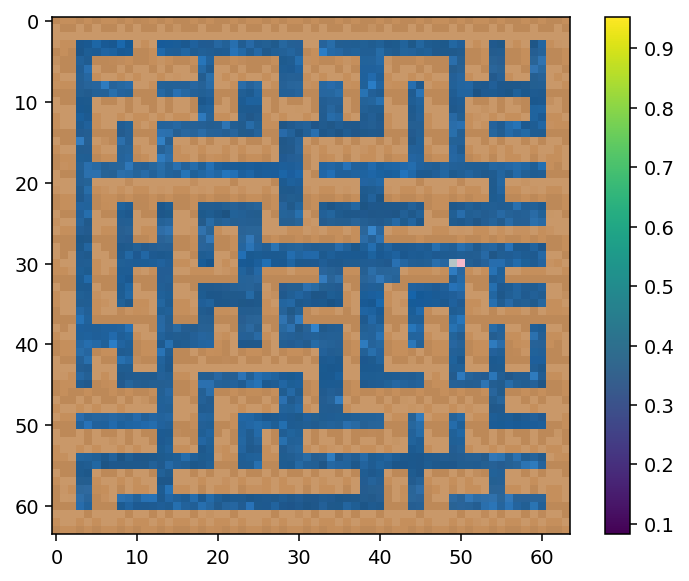

The predicted correct move in this scenario is:  LEFT  with probability  0.8091117441654205 %


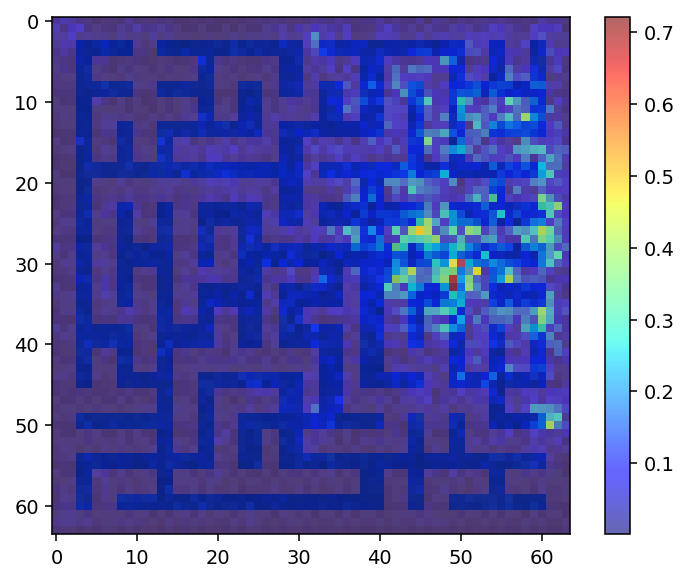

In [170]:
# It still thinks going up is the best move but not because of the top right hand corner. If we seal that off, what will it think?

middle_map = get_grids()
plt.imshow(t.swapaxes(middle_map[:1].squeeze(axis=0), 1, 2).numpy().T)
plt.colorbar()
plt.show()

sal_map = saliency_for_move(middle_map[:1], policy)

plt.imshow(middle_map[:1].squeeze(axis=0).numpy().transpose(1,2,0))
plt.imshow(sal_map, cmap='jet', alpha=0.6)
plt.colorbar()
plt.show()

It's much more sure it wants to go to the top right. 

Okay, now what if the cheese is in the other direction?

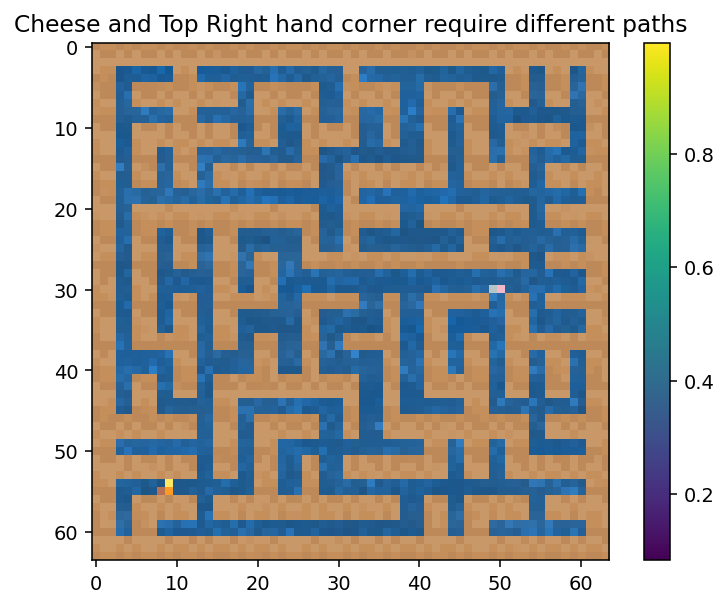

The predicted correct move in this scenario is:  RIGHT  with probability  0.6966055929660797 %


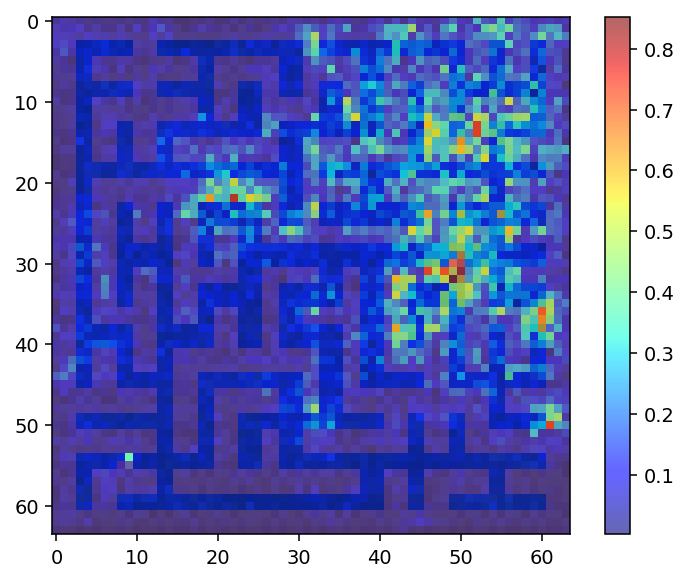

In [172]:
# It still thinks going up is the best move but not because of the top right hand corner. If we seal that off, what will it think?

middle_map = get_grids()
plt.imshow(t.swapaxes(middle_map[:1].squeeze(axis=0), 1, 2).numpy().T)
plt.title("Cheese and Top Right hand corner require different paths")
plt.colorbar()
plt.show()

sal_map = saliency_for_move(middle_map[:1], policy)

plt.imshow(middle_map[:1].squeeze(axis=0).numpy().transpose(1,2,0))
plt.imshow(sal_map, cmap='jet', alpha=0.6)
plt.colorbar()
plt.show()

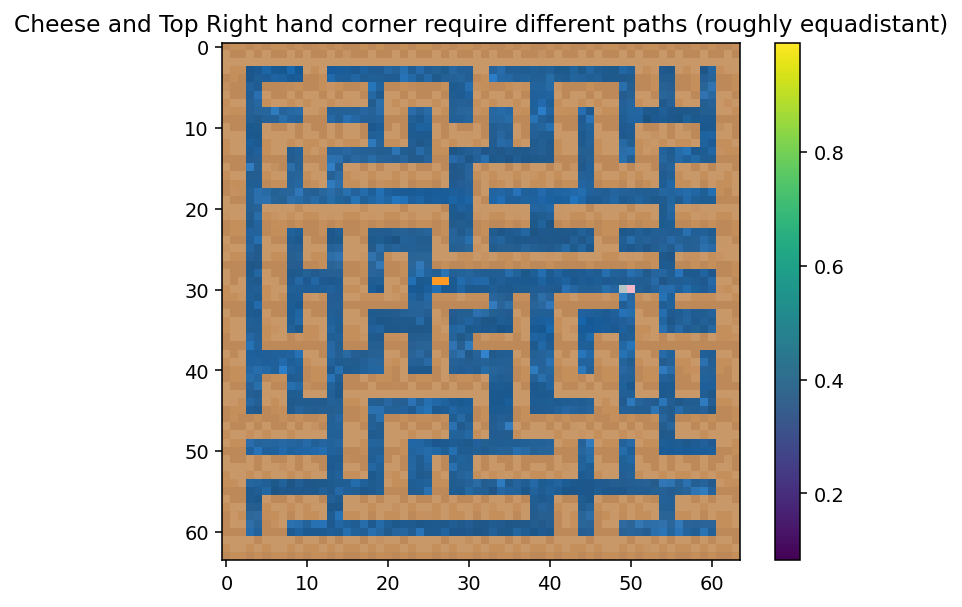

The predicted correct move in this scenario is:  RIGHT  with probability  0.5112273395061493 %


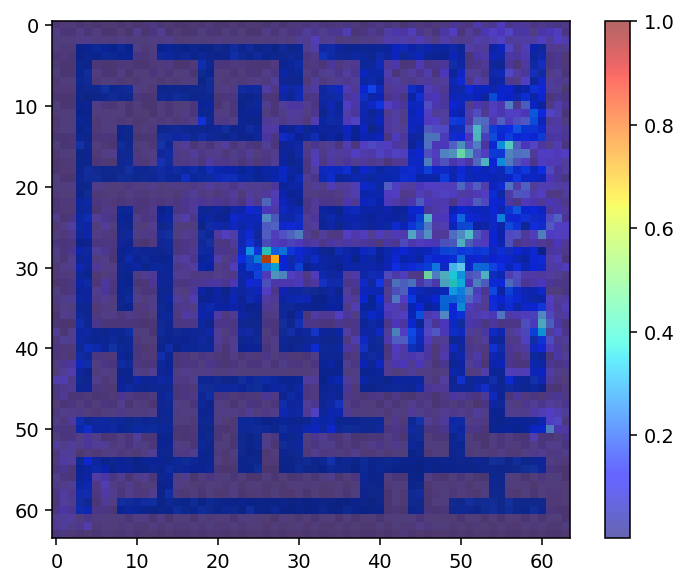

In [173]:
# Path to the top right hand corner is preferred. Does the model change its mind when the cheese and the lower right bounding box for the right hand 
# corner are identical (using x=52 and y=14 to judge bottom left corner of top right bounding box)

middle_map = get_grids()
plt.imshow(t.swapaxes(middle_map[:1].squeeze(axis=0), 1, 2).numpy().T)
plt.title("Cheese and Top Right hand corner require different paths (roughly equadistant)")
plt.colorbar()
plt.show()

sal_map = saliency_for_move(middle_map[:1], policy)

plt.imshow(middle_map[:1].squeeze(axis=0).numpy().transpose(1,2,0))
plt.imshow(sal_map, cmap='jet', alpha=0.6)
plt.colorbar()
plt.show()

That's really interesting. The cheese is identified more out of anything else, and used more than anything else to identify that it should go the opposite way.

We can identify the highest probability singular move as well with this function

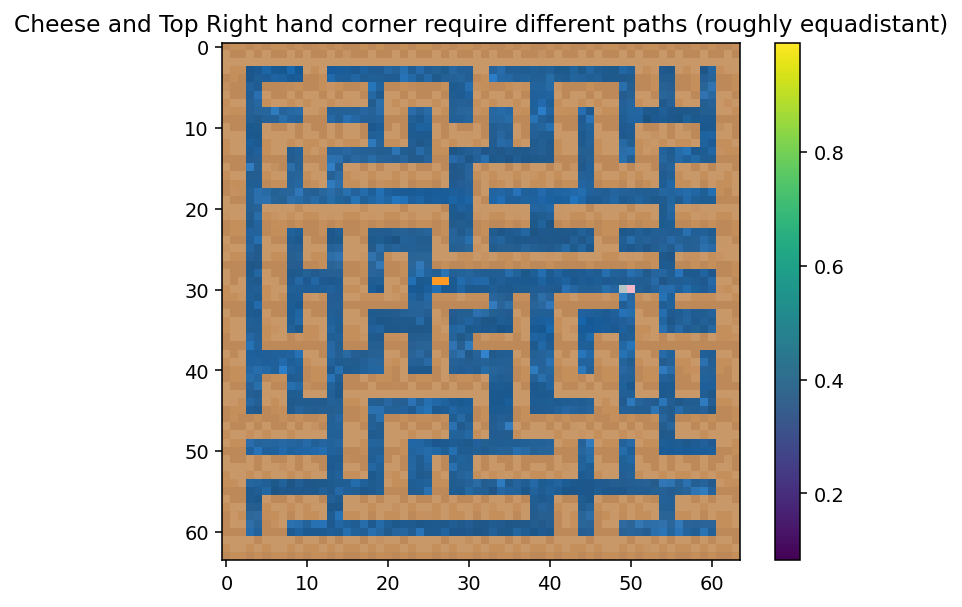

probabiltiy distribution:  [[0.04392643 0.05318235 0.07662433 0.10068998 0.02079279 0.0846008
  0.22191201 0.17411222 0.11520311 0.01800704 0.01816388 0.01304777
  0.00933538 0.00727149 0.04313032]]
The predicted correct move in this scenario is:  6  with probability  tensor(0.2219, grad_fn=<SelectBackward0>) %


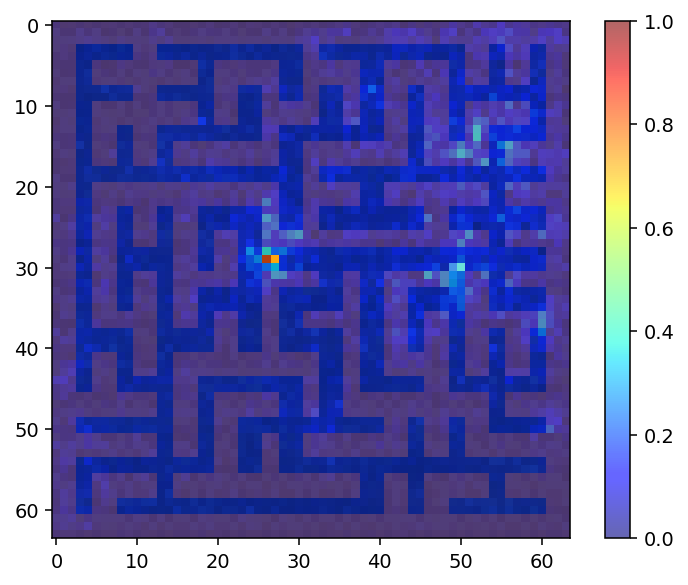

In [180]:

middle_map = get_grids()
plt.imshow(t.swapaxes(middle_map[:1].squeeze(axis=0), 1, 2).numpy().T)
plt.title("Cheese and Top Right hand corner require different paths (roughly equadistant)")
plt.colorbar()
plt.show()

sal_map = saliency(middle_map[:1], policy)

plt.imshow(middle_map[:1].squeeze(axis=0).numpy().transpose(1,2,0))
plt.imshow(sal_map, cmap='jet', alpha=0.6)
plt.colorbar()
plt.show()

So the highest option it has is for going right, with a 22% chance. What's even more interesting is that it identifies the cheese the most, yet the collective probability it has for going left is less than 20%. 

Okay, so given that the model was trained in an environment where the cheese was always in the top right, the model might have created bias in the moves itself, where right is favoured over left, and up is favoured over down. We might be able to highlight that if the cheese was placed on the right, but the path to the top right required a move to the left.

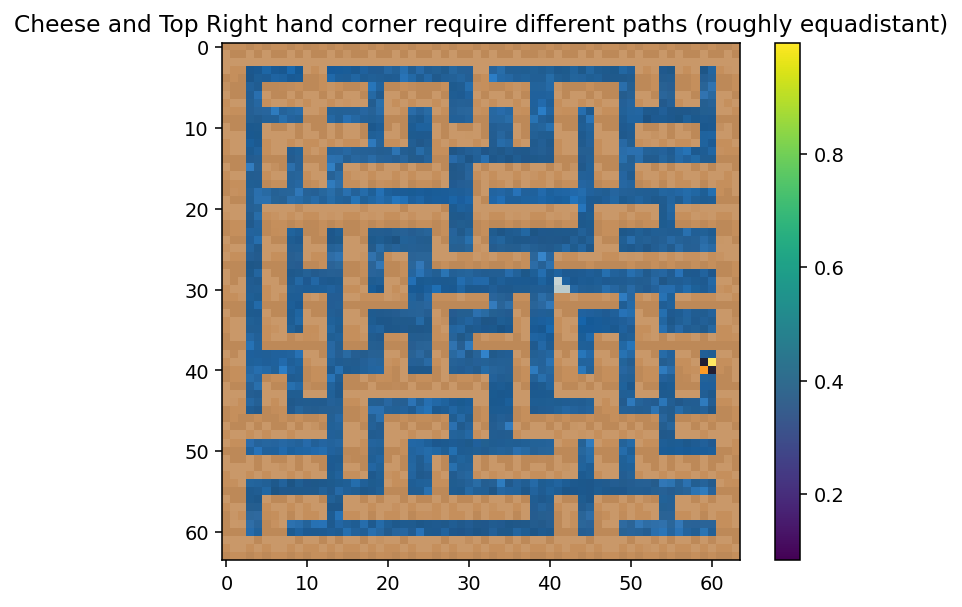

The predicted correct move in this scenario is:  LEFT  with probability  0.67784383893013 %


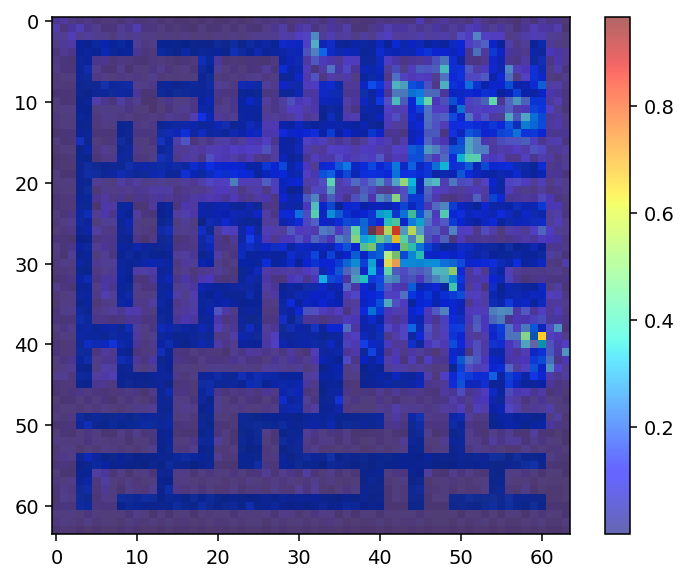

In [183]:

middle_map = get_grids()
plt.imshow(t.swapaxes(middle_map[:1].squeeze(axis=0), 1, 2).numpy().T)
plt.title("Cheese and Top Right hand corner require different paths (roughly equadistant)")
plt.colorbar()
plt.show()

sal_map = saliency_for_move(middle_map[:1], policy)

plt.imshow(middle_map[:1].squeeze(axis=0).numpy().transpose(1,2,0))
plt.imshow(sal_map, cmap='jet', alpha=0.6)
plt.colorbar()
plt.show()

probabiltiy distribution:  [[0.16371347 0.19247012 0.32166025 0.02313856 0.01307291 0.01488551
  0.05030524 0.0861101  0.0101364  0.00382992 0.00557117 0.0064946
  0.01360409 0.00677148 0.08823609]]
The predicted correct move in this scenario is:  2  with probability  tensor(0.3217, grad_fn=<SelectBackward0>) %


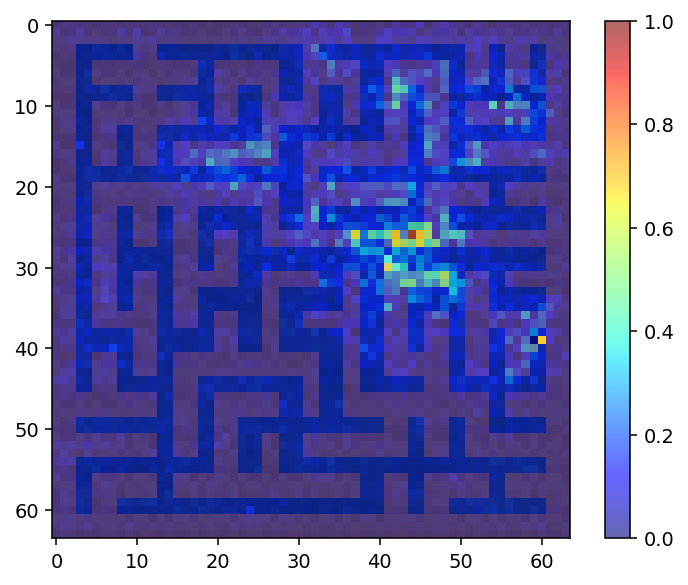

In [184]:
# Nope, okay so it actually does just prioritize the top left. What is the probability of it going right?

sal_map = saliency(middle_map[:1], policy)

plt.imshow(middle_map[:1].squeeze(axis=0).numpy().transpose(1,2,0))
plt.imshow(sal_map, cmap='jet', alpha=0.6)
plt.colorbar()
plt.show()

In [185]:
# A combined probability of ~15%. wild.